In [1]:
!pip3 install numpy==1.15.4
!pip3 install pandas==0.25.2

     |████████████████████████████████| 13.9MB 173kB/s 
ERROR: tensorflow 1.15.0 has requirement numpy<2.0,>=1.16.0, but you'll have numpy 1.15.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.17.4
    Uninstalling numpy-1.17.4:
      Successfully uninstalled numpy-1.17.4


     |████████████████████████████████| 10.4MB 2.7MB/s 
  Found existing installation: pandas 0.25.3
    Uninstalling pandas-0.25.3:
      Successfully uninstalled pandas-0.25.3


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc
import math
import random
import matplotlib
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.patches as patches
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 30)
from datetime import datetime
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
path='../input/ashrae-energy-prediction/'
path_new = '../input/lag-transform/'
path_new = '../input/transformer/'
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from math import log
import lightgbm as lgb
import datetime
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
pd.options.mode.chained_assignment = None
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import holidays
import os

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))
def ls():
     print([v for v in globals().keys() if not v.startswith('_')])

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    
def free_space(del_list):
    for name in del_list:
        if not name.startswith('_'):
            del globals()[name]
    gc.collect()
    
def chunk_predictor(X,model,n=100,verbose=True):
    predict_fold = KFold(n)
    result = np.zeros(X.shape[0])
    if verbose:
        for trn_idx, val_idx in tqdm_notebook(predict_fold.split(X)):
               result[val_idx] = model.predict(X.iloc[val_idx,:])
    else:
        for trn_idx, val_idx in predict_fold.split(X):
            result[val_idx] = model.predict(X.iloc[val_idx,:])
    return(result)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
path_load = '/content/drive/My Drive/Ashae/'
train = pd.read_hdf(f'{path_load}dataset.h5',key='train')
column = pd.read_hdf(f'{path_load}dataset.h5',key='column')['column'].tolist()
category_column = pd.read_hdf(f'{path_load}dataset.h5',key='category_column')['cat_column'].tolist()
target = pd.read_hdf(f'{path_load}dataset.h5',key='target_site0_mod')
gc.collect()

88

In [4]:
SEED = 42
seed_everything(SEED)
gc.collect()

0

In [0]:
seed = 1
params = {
                    'objective': 'regression',
                    'boosting_type':'gbdt',
                    'metric':'rmse',
                    'learning_rate':0.05,
                    'colsample_bytree': 0.7699242354175626,
                    'lambda_l1': 1.7233942541747633,
                    'lambda_l2': 1.835065251306714,
                    'max_depth': int(69.45971425060898),
                    'min_data_in_leaf': int(30.792304068114845),
                    'min_gain_to_split': 0.3262201710999464,
                    'min_sum_hessian_in_leaf': 0.007097047333357153,
                    'num_leaves': int(510.37557713422353),
                    'subsample': 0.7385647527529277,
                    'tree_learner':'serial',
                    'max_bin':255,
                    'seed': seed,
                    'n_jobs':-1,
                    'importance_type':'gain',
                    'early_stopping_rounds':50, 
}

In [6]:
%%time
strat =train['building_id'].astype(str).copy() + train['meter'].astype(str).copy()
le = LabelEncoder()
strat = le.fit_transform(strat).astype(np.int16)
free_space(['le'])
gc.collect()

CPU times: user 38 s, sys: 6.23 s, total: 44.3 s
Wall time: 44.1 s


In [0]:
leak = [0,1,2,15]
weight_train = train['building_id'].map(1/train['building_id'].value_counts())
# weight_test = (~np.isin(train['site_id'],leak)).astype(int)

In [7]:
%%time
gc.collect()
num_boost=0

score = 0
n_fold = 2
folds = StratifiedKFold(n_splits=n_fold, shuffle=False,random_state=0)
pred = np.zeros(train.shape[0])
model5 =[]

gc.collect()
for fold_ , (trn_idx, val_idx) in tqdm_notebook(enumerate(folds.split(train,strat))):
        gc.collect()
        train_x, train_y = train.iloc[trn_idx,:], target.iloc[trn_idx]
        valid_x, valid_y = train.iloc[val_idx,:], target.iloc[val_idx]
        model = lgb.train(params,lgb.Dataset(train_x, label=train_y,categorical_feature=category_column), 
                          3500, valid_sets = lgb.Dataset(valid_x, label=valid_y,categorical_feature=category_column),valid_names ='validation', #, weight = weight_test[val_idx]
                          verbose_eval=10)
        gc.collect()
        model5.append(model)
        num_boost += model.best_iteration/n_fold
        pred[val_idx] = chunk_predictor(valid_x,model,verbose=False)
        
        score += model.best_score['validation']['rmse']/n_fold #math.sqrt(mean_squared_error(valid_y,pred[val_idx]))/n_fold
        print('Fold: {}; RMSE: {:.3f}\n'.format(fold_,model.best_score['validation']['rmse']/n_fold))
        free_space(['model','train_x','train_y','valid_x','valid_y','trn_idx','val_idx'])
        
print('RLMSE : {} ; iteration : {}\n'.format(score,num_boost))
valid_build = train['building_id'].copy()
valid_meter = train['meter'].copy()
gc.collect()

Training until validation scores don't improve for 50 rounds.
[10]	validation's rmse: 1.38987
[20]	validation's rmse: 1.11257
[30]	validation's rmse: 0.970684
[40]	validation's rmse: 0.905232
[50]	validation's rmse: 0.873306
[60]	validation's rmse: 0.856963
[70]	validation's rmse: 0.848595
[80]	validation's rmse: 0.843391
[90]	validation's rmse: 0.839493
[100]	validation's rmse: 0.837168
[110]	validation's rmse: 0.836733
[120]	validation's rmse: 0.835794
[130]	validation's rmse: 0.835851
[140]	validation's rmse: 0.836142
[150]	validation's rmse: 0.836384
[160]	validation's rmse: 0.836434
[170]	validation's rmse: 0.836665
Early stopping, best iteration is:
[123]	validation's rmse: 0.835422
Fold: 0; RMSE: 0.418

Training until validation scores don't improve for 50 rounds.
[10]	validation's rmse: 1.42946
[20]	validation's rmse: 1.1572
[30]	validation's rmse: 1.01818
[40]	validation's rmse: 0.947319
[50]	validation's rmse: 0.911005
[60]	validation's rmse: 0.889258
[70]	validation's rmse: 

In [0]:
result = pd.DataFrame({'Building_ID':valid_build,'meter':valid_meter,'target_real':target,'target_pred':pred}).dropna()
result.reset_index(drop=True,inplace=True)
gc.collect()

free_space(['valid_build','valid_meter','pred'])

gc.collect()

0

In [0]:
%%time
test = pd.read_hdf(f'{path_load}dataset.h5',key='test')

gc.collect()

pred_test = np.zeros(test.shape[0])

print('Begin scoring test set...\n')

feature_importances = pd.DataFrame()
feature_importances['feature'] = test.columns


for fold_, mod in tqdm_notebook(enumerate(model5)):
    feature_importances['fold_{}'.format(fold_ + 1)] = mod.feature_importance(importance_type='gain')
    pred_test += np.expm1(chunk_predictor(test,mod,verbose=False))/n_fold

Begin scoring test set...




CPU times: user 2h 48s, sys: 3.31 s, total: 2h 51s
Wall time: 31min 26s


In [0]:
pred_test[(test.site_id==0) & (test.meter==0)] = pred_test[(test.site_id==0) & (test.meter==0)] * 3.4118

gc.collect()
sample_submission = pd.read_csv(f'{path_load}sample_submission.csv')
sample_submission['meter_reading'] = pred_test
sample_submission.loc[sample_submission['meter_reading']<0, 'meter_reading'] = 0
sample_submission.to_csv('{}submission/submission_lgbm_score{}.csv'.format(path_load,score),index=False)

In [0]:
sample_submission.iloc[:50,:]

,row_id,meter_reading
0,0,197.310433
1,1,91.169316
2,2,13.488374
3,3,316.542618
4,4,1342.256536
...,...,...
45,45,103.579801
46,46,158.111897
47,47,456.217884
48,48,271.358271


In [0]:
def fun_rmse_group(x):
    return(math.sqrt(mean_squared_error(x['target_real'],x['target_pred'])))

rmse_group_data = result.groupby(['Building_ID','meter']).apply(fun_rmse_group)
score_by_group = rmse_group_data.mean()

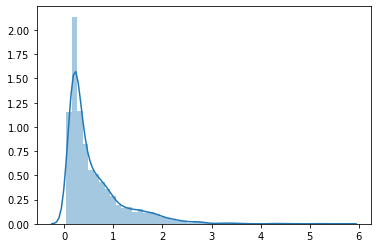

In [0]:
sns.distplot(rmse_group_data,label='RMSE by Building ID and meter')

In [0]:
print('Mean RMSLE by building and meter : {}'.format(score_by_group))

Mean RMSLE by building and meter : 0.6061744766237944


In [0]:
error_id = rmse_group_data.sort_values(ascending =False)
error_id = pd.DataFrame({'building_id':rmse_group_data.sort_values(ascending =False).index.get_level_values('Building_ID'),
                         'meter':rmse_group_data.sort_values(ascending =False).index.get_level_values('meter'),'error':error_id.values})
error_id.to_csv('error_by_id.csv',index=False)

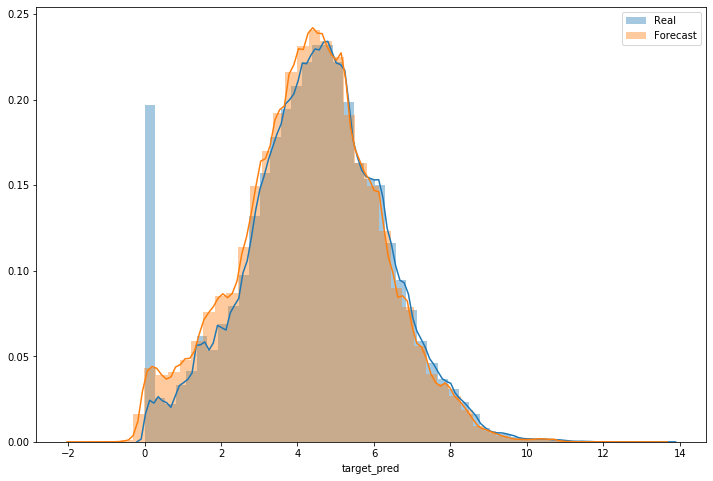

In [0]:
fig = plt.figure(figsize=(12,8))
sns.distplot(result.target_real,label='Real')
sns.distplot(result.target_pred,label='Forecast')
plt.legend()


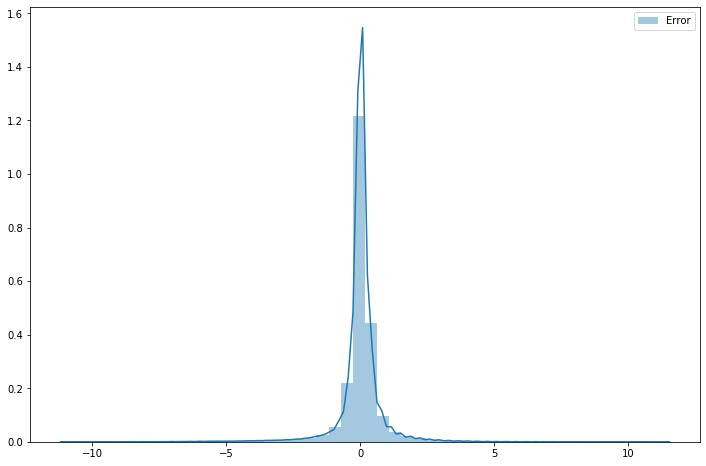

In [0]:
import seaborn as sns 
fig = plt.figure(figsize=(12,8))
sns.distplot((result.target_real-result.target_pred),label ='Error')
plt.legend()


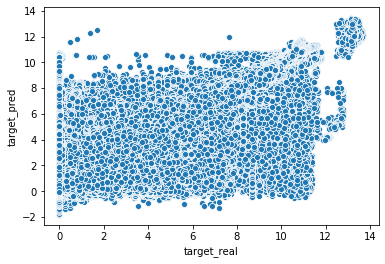

In [0]:
sns.scatterplot(x=result.target_real, y=result.target_pred)


Text(0.5, 1.0, '50 TOP feature importance over 2 average')

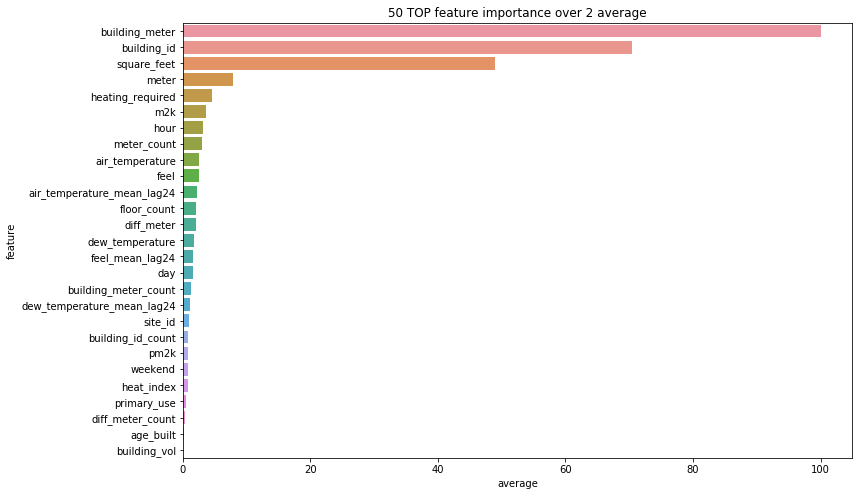

In [0]:
scaler = MinMaxScaler(feature_range=(0, 100))


feature_importances['average'] = scaler.fit_transform(X=pd.DataFrame(feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)))
# feature_importances.to_csv('feature_importances.csv',index=False)

fig = plt.figure(figsize=(12,8))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} average'.format(fold_+1))
